In [2]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [3]:
os.chdir('C:/Users/Kyeongjun/Desktop/LG가전데이터')

dailytotal = pd.read_csv('dailytotal.csv')
dailytotal = dailytotal.sort_values(by=['DEVICE_ID','day'])
dailytotal = dailytotal.reset_index(drop=True)
dailytotal['total_t'] = dailytotal['micro_t'] + dailytotal['oven_t'] + dailytotal['others_t']
dailytotal = dailytotal.sort_values(by= ['DEVICE_ID','day'])


# 0. Preprocessing

## 0-1. define function of GESD Anomaly detection

In [4]:
# GESD는 통계량의 평균으로부터 가장 멀리 떨어진 점까지의 거리를 표준편차로 나눈 R(i)값을
# t-distribution에서 유도되는 t값에 관한 식(lambda(i))과 비교하여 이상치로 분류하는 기법입니다.
# (밑에 작성된 함수들에 포함된 '#'을 제거하면 print문을 통해 GESD 진행과정을 볼 수 있습니다.)
 
# test_stat = R(i)를 계산하는 함수입니다.
def test_stat(y, iteration):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    cal = max_of_deviations/ std_dev
    #print('Test {}'.format(iteration))
    #print("Test Statistics Value(R{}) : {}".format(iteration,cal))
    return cal, max_ind

# critical_value = lambda(i)를 계산하는 함수입니다.
def calculate_critical_value(size, alpha, iteration):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    #print("Critical Value(λ{}): {}".format(iteration, critical_value))
    return critical_value

# R(i)와 lambda(i)를 비교하는 과정을 print해주는 함수입니다.
def check_values(R, C, inp, max_index, iteration):
    if R > C:
        print('{} is an outlier. R{} > λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))
    else:
        print('{} is not an outlier. R{}> λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))

# ESD 테스트 함수입니다.
# 입력으로 Anomaly detection을 진행할 input_series와 유의확률 alpha, max_outliers 개수가 들어갑니다.
# 출력으로 out_lier 개수가 나옵니다.
def ESD_Test(input_series, alpha, max_outliers):
    stats = []
    critical_vals = []
    k = 0
    for iterations in range(1, max_outliers + 1):
        stat, max_index = test_stat(input_series, iterations)
        critical = calculate_critical_value(len(input_series), alpha, iterations)
        #check_values(stat, critical, input_series, max_index, iterations)
        input_series = np.delete(input_series, max_index)
        critical_vals.append(critical)
        stats.append(stat)
        if stat > critical:
            max_i = iterations
            k += 1
    #print('H0:  there are no outliers in the data')
    #print('Ha:  there are up to 10 outliers in the data')
    #print('')
    #print('Significance level:  α = {}'.format(alpha))
    #print('Critical region:  Reject H0 if Ri > critical value')
    #print('Ri: Test statistic')
    #print('λi: Critical Value')
    #print(' ')
    df = pd.DataFrame({'i' :range(1, max_outliers + 1), 'Ri': stats, 'λi': critical_vals})
    
    def highlight_max(x):
        if x.i == max_i:
            return ['background-color: yellow']*3
        else:
            return ['background-color: white']*3
    df.index = df.index + 1
    #print('Number of outliers {}'.format(max_i))
    
    return  k

# 1. One-variable GESD

## 1-1. total cooktime GESD

In [10]:
anomaly = []
for i in list(set(dailytotal['DEVICE_ID'])):
    df = dailytotal.loc[dailytotal['DEVICE_ID'] == i,]
    anomaly.append(ESD_Test(np.array(df['total_t']), 0.05, len(df)))

np.mean(anomaly)

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


43.56310679611651

## 1-2. micro cooktime GESD

In [11]:
anomaly_m = []
for i in list(set(dailytotal['DEVICE_ID'])) :
    df = dailytotal.loc[dailytotal['DEVICE_ID'] == i,]

    anomaly_m.append(ESD_Test(np.array(df['micro_t']), 0.05, len(df)))

np.mean(anomaly_m)

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


17.563106796116504

## 1-3. oven cooktime GESD

In [13]:
anomaly_o = []
for i in list(set(dailytotal['DEVICE_ID'])) :
    df = dailytotal.loc[dailytotal['DEVICE_ID'] == i,]

    anomaly_o.append(ESD_Test(np.array(df['oven_t']), 0.05, len(df)))

np.mean(anomaly_o)

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


38.95145631067961

## 1-4. others cooktime GESD

In [14]:
anomaly_e = []
for i in list(set(dailytotal['DEVICE_ID']))[:34] + list(set(dailytotal['DEVICE_ID']))[35:87]+ list(set(dailytotal['DEVICE_ID']))[88:] :
    df = dailytotal.loc[dailytotal['DEVICE_ID'] == i,]

    anomaly_e.append(ESD_Test(np.array(df['others_t']), 0.05, len(df)))

np.mean(anomaly_e)

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


43.257425742574256

평균 43.56,  17.56, 38.95, 43.26개의 outlier를 관측했습니다.

In [15]:
del i, anomaly, anomaly_m, anomaly_o, anomaly_e

# 2. Two-variable PCA GESD

## 2-0. PCA function

In [16]:
def PCAdf(df, col1, col2):
    df0 = df.loc[:,['DEVICE_ID',col1, col2]]
    returndf = pd.DataFrame()
    for i in list(set(df0.DEVICE_ID)) :
        df1 = df0.loc[df0['DEVICE_ID'] == i,:]
        
        pca = PCA(n_components=2)
        components = pca.fit_transform(df1.loc[:,[col1,col2]])
        dfk = pd.DataFrame(data = components, columns = ['pc1', 'pc2'])
        dfk['DEVICE_ID'] = i
        returndf = returndf.append(dfk)
    returndf = returndf[['DEVICE_ID','pc1','pc2']]
    return returndf

## 2-1. total_t & micro_t

In [17]:
pca_tm = PCAdf(dailytotal, 'total_t', 'micro_t')

anomaly_cp1 = []
for i in list(set(pca_tm['DEVICE_ID'])):
    df = pca_tm.loc[pca_tm['DEVICE_ID'] == i,:]

    anomaly_cp1.append(ESD_Test(np.array(df['pc1']), 0.05, len(df)))

anomaly_cp2 = []
for i in list(set(pca_tm['DEVICE_ID'])) :
    df = pca_tm.loc[pca_tm['DEVICE_ID'] == i,:]

    anomaly_cp2.append(ESD_Test(np.array(df['pc2']), 0.05, len(df)))

np.mean(anomaly_cp1)

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


43.23300970873787

In [18]:
np.mean(anomaly_cp2)

27.02912621359223

In [19]:
del i, anomaly_cp1, anomaly_cp2, pca_tm

## 2-2. total_t & oven_t

In [20]:
pca_to = PCAdf(dailytotal, 'total_t', 'oven_t')

anomaly_cp1 = []
for i in list(set(pca_to['DEVICE_ID'])):
    df = pca_to.loc[pca_to['DEVICE_ID'] == i,:]

    anomaly_cp1.append(ESD_Test(np.array(df['pc1']), 0.05, len(df)))

anomaly_cp2 = []
for i in list(set(pca_to['DEVICE_ID'])) :
    df = pca_to.loc[pca_to['DEVICE_ID'] == i,:]

    anomaly_cp2.append(ESD_Test(np.array(df['pc2']), 0.05, len(df)))

np.mean(anomaly_cp1)

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


47.300970873786405

In [21]:
np.mean(anomaly_cp2)

47.029126213592235

In [22]:
del i, anomaly_cp1, anomaly_cp2, pca_to

## 2-3. total_t & others_t

In [23]:
pca_te = PCAdf(dailytotal, 'total_t', 'others_t')

anomaly_cp1 = []
for i in list(set(pca_te['DEVICE_ID'])):
    df = pca_te.loc[pca_te['DEVICE_ID'] == i,:]

    anomaly_cp1.append(ESD_Test(np.array(df['pc1']), 0.05, len(df)))

anomaly_cp2 = []
for i in list(set(pca_te['DEVICE_ID'])) :
    df = pca_te.loc[pca_te['DEVICE_ID'] == i,:]

    anomaly_cp2.append(ESD_Test(np.array(df['pc2']), 0.05, len(df)))

np.mean(anomaly_cp1)

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


48.87378640776699

In [24]:
np.mean(anomaly_cp2)

43.650485436893206

In [25]:
del i, anomaly_cp1, anomaly_cp2, pca_te

## 2-4. others_t & micro_t

In [26]:
pca_em = PCAdf(dailytotal, 'others_t', 'micro_t')

anomaly_cp1 = []
for i in list(set(pca_em['DEVICE_ID'])):
    df = pca_em.loc[pca_em['DEVICE_ID'] == i,:]

    anomaly_cp1.append(ESD_Test(np.array(df['pc1']), 0.05, len(df)))

anomaly_cp2 = []
for i in list(set(pca_em['DEVICE_ID'])) :
    df = pca_em.loc[pca_em['DEVICE_ID'] == i,:]

    anomaly_cp2.append(ESD_Test(np.array(df['pc2']), 0.05, len(df)))

np.mean(anomaly_cp1)

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


55.44660194174757

In [27]:
np.mean(anomaly_cp2)

25.145631067961165

In [28]:
del i, anomaly_cp1, anomaly_cp2, pca_em

## 2-5. othres_t & oven_t

In [29]:
pca_eo = PCAdf(dailytotal, 'others_t', 'oven_t')

anomaly_cp1 = []
for i in list(set(pca_eo['DEVICE_ID'])):
    df = pca_eo.loc[pca_eo['DEVICE_ID'] == i,:]

    anomaly_cp1.append(ESD_Test(np.array(df['pc1']), 0.05, len(df)))

anomaly_cp2 = []
for i in list(set(pca_eo['DEVICE_ID'])) :
    df = pca_eo.loc[pca_eo['DEVICE_ID'] == i,:]

    anomaly_cp2.append(ESD_Test(np.array(df['pc2']), 0.05, len(df)))

np.mean(anomaly_cp1)

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


67.9126213592233

In [30]:
np.mean(anomaly_cp2)

67.52427184466019

In [31]:
del i, anomaly_cp1, anomaly_cp2, pca_eo

## 2-6. micro_t & oven_t

In [32]:
pca_mo = PCAdf(dailytotal, 'micro_t', 'oven_t')

anomaly_cp1 = []
for i in list(set(pca_mo['DEVICE_ID'])):
    df = pca_mo.loc[pca_mo['DEVICE_ID'] == i,:]

    anomaly_cp1.append(ESD_Test(np.array(df['pc1']), 0.05, len(df)))

anomaly_cp2 = []
for i in list(set(pca_mo['DEVICE_ID'])) :
    df = pca_mo.loc[pca_mo['DEVICE_ID'] == i,:]

    anomaly_cp2.append(ESD_Test(np.array(df['pc2']), 0.05, len(df)))

np.mean(anomaly_cp1)

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


53.883495145631066

In [33]:
np.mean(anomaly_cp2)

25.07766990291262

In [34]:
del i, anomaly_cp1, anomaly_cp2, pca_mo

component 1/2에서 평균 42.23/27.03, 47.30/47.03, 48.87/43.65, 55.45/25.15, 67.91/67.52, 53.88/25.08개의 outlier를 관측했습니다.

# 3. Visualizing one&two-variable GESD

## 3-0. select certain device

In [35]:
# 요리한 날짜가 가장 많은 device 선택
dailytotal['DEVICE_ID'].value_counts() # DEVICE_ID : id_00022
dev_id = 'id_00022'

df = dailytotal.loc[dailytotal['DEVICE_ID'] == dev_id,]

def outlier_df(time_var) :
    # 1. id_00022 device의 outlier 개수(n)를 파악한 뒤,
    # 2. time_var를 기준으로 평균과 가장 멀리 떨어진 n개의 index를 파악
    # 3. 해당 index의 day와 value를 dataframe(df)으로 생성
    n = ESD_Test(np.array(df[time_var]), 0.05, len(df))
    df0 = df.copy(deep=True)
    df0['dist'] = abs(np.mean(df0[time_var]) - df0[time_var])
    ind = list(df0.sort_values(by='dist', ascending = False).iloc[:n,:].index)
    df0 = df.loc[ind,['day',time_var]]
    
    return df0

def PCAdf(df, col1, col2):
    df0 = df.loc[:,['DEVICE_ID',col1, col2]]
    returndf = pd.DataFrame()
    for i in list(set(df0.DEVICE_ID)) :
        df1 = df0.loc[df0['DEVICE_ID'] == i,:]
        
        pca = PCA(n_components=2)
        components = pca.fit_transform(df1.loc[:,[col1,col2]])
        dfk = pd.DataFrame(data = components, columns = ['pc1', 'pc2'])
        dfk['DEVICE_ID'] = i
        returndf = returndf.append(dfk)
    returndf = returndf[['DEVICE_ID','pc1','pc2']]
    return returndf

def outlier_df2(df,time_var) :
    # 1. id_00022 device의 outlier 개수(n)를 파악한 뒤,
    # 2. time_var를 기준으로 평균과 가장 멀리 떨어진 n개의 index를 파악
    # 3. 해당 index의 day와 value를 dataframe(df)으로 생성
    n = ESD_Test(np.array(df[time_var]), 0.05, len(df))
    df0 = df.copy(deep=True)
    df0['dist'] = abs(np.mean(df0[time_var]) - df0[time_var])
    ind = list(df0.sort_values(by='dist', ascending = False).iloc[:n,:].index)
    df0 = df.loc[ind,['day',time_var]]
    
    return df0

## 3-1. one-variable GESD visualization

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Text(0, 0.5, 'total_t')

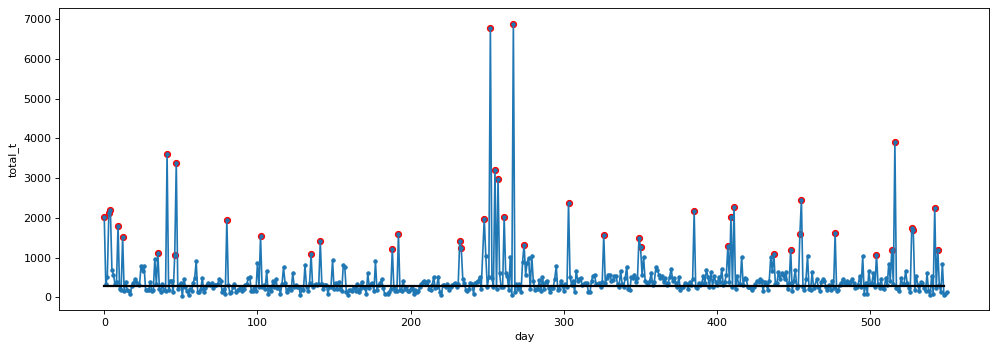

In [36]:
# total_t
figure(figsize=(15, 5), dpi=80)
plt.plot(df['day'], df['total_t'], marker = 'o', markersize = 3)
plt.scatter(list(outlier_df('total_t').iloc[:,0]),list(outlier_df('total_t').iloc[:,1]),s=30, color ='r')
plt.plot([0, df.shape[0]], [np.mean(df.iloc[:,1]),np.mean(df.iloc[:,1])], 'k-', lw=2)
plt.xlabel('day')
plt.ylabel('total_t')

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Text(0, 0.5, 'micro_t')

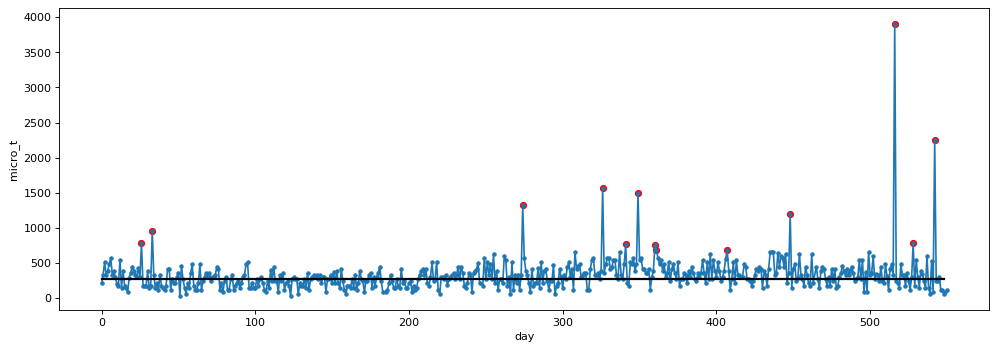

In [37]:
# micro_t
figure(figsize=(15, 5), dpi=80)
plt.plot(df['day'], df['micro_t'], marker = 'o', markersize = 3)
plt.scatter(list(outlier_df('micro_t').iloc[:,0]),list(outlier_df('micro_t').iloc[:,1]),s=30, color ='r')
plt.plot([0, df.shape[0]], [np.mean(df.iloc[:,1]),np.mean(df.iloc[:,1])], 'k-', lw=2)
plt.xlabel('day')
plt.ylabel('micro_t')


C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Text(0, 0.5, 'oven_t')

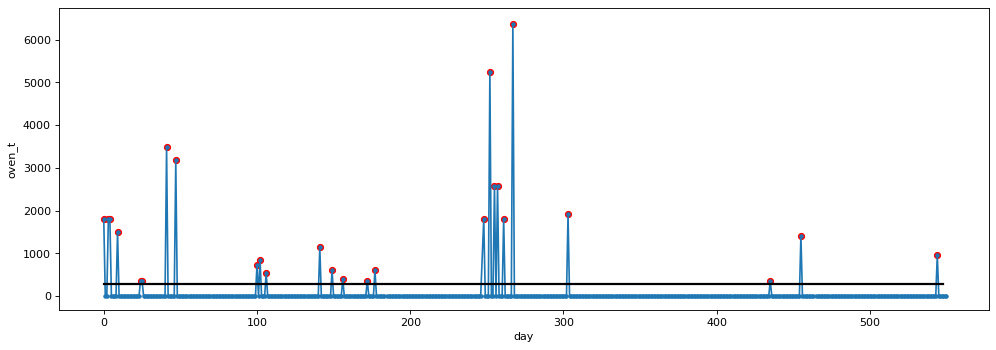

In [38]:
# oven_t
figure(figsize=(15, 5), dpi=80)
plt.plot(df['day'], df['oven_t'], marker = 'o', markersize = 3)
plt.scatter(list(outlier_df('oven_t').iloc[:,0]),list(outlier_df('oven_t').iloc[:,1]),s=30, color ='r')
plt.plot([0, df.shape[0]], [np.mean(df.iloc[:,1]),np.mean(df.iloc[:,1])], 'k-', lw=2)
plt.xlabel('day')
plt.ylabel('oven_t')


C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Text(0, 0.5, 'others_t')

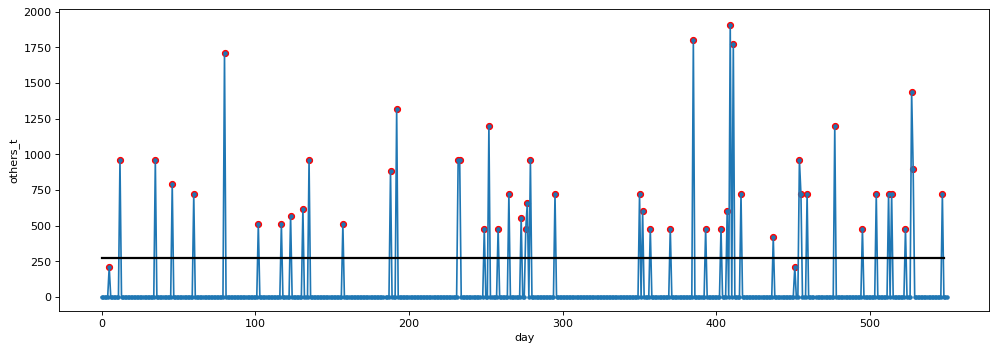

In [39]:
# others_t
figure(figsize=(15, 5), dpi=80)
plt.plot(df['day'], df['others_t'], marker = 'o', markersize = 3)
plt.scatter(list(outlier_df('others_t').iloc[:,0]),list(outlier_df('others_t').iloc[:,1]),s=30, color ='r')
plt.plot([0, df.shape[0]], [np.mean(df.iloc[:,1]),np.mean(df.iloc[:,1])], 'k-', lw=2)
plt.xlabel('day')
plt.ylabel('others_t')


## 3-2. two-variables PCA GESD visualization (total_t & micro_t)

In [40]:
pca = PCA(n_components=2)
components = pca.fit_transform(df.loc[:,['total_t','micro_t']])
df_pca = pd.DataFrame(data = components, columns = ['pc1', 'pc2'])
df_pca ['day'] = list(df.day)
df_pca = df_pca[['day','pc1','pc2']]

In [41]:
# joint outlier df
a = list(outlier_df2(df_pca,'pc1').index)
b = list(outlier_df2(df_pca,'pc2').index)
a.extend(b)
joint_ind = list(set(a))

del a,b


C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Text(0, 0.5, 'pc2')

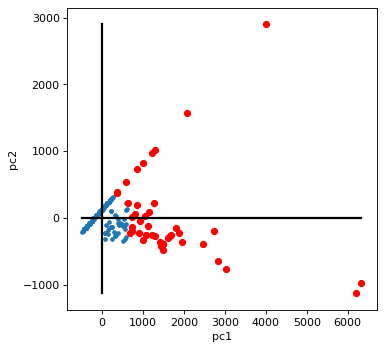

In [42]:
# joint control region
figure(figsize=(5, 5), dpi=80)
plt.scatter(df_pca['pc1'], df_pca['pc2'], s=10)
plt.plot([min(df_pca.iloc[:,1]), max(df_pca.iloc[:,1])], [np.mean(df_pca.iloc[:,1]),np.mean(df_pca.iloc[:,1])], 'k-', lw=2)
plt.plot([np.mean(df_pca.iloc[:,2]),np.mean(df_pca.iloc[:,2])], [min(df_pca.iloc[:,2]), max(df_pca.iloc[:,2])], 'k-', lw=2)
plt.scatter(list(df_pca.loc[joint_ind,].iloc[:,1]),list(df_pca.loc[joint_ind,].iloc[:,2]),s=30, color ='r')
plt.xlabel('pc1')
plt.ylabel('pc2')


C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Text(0, 0.5, 'pc1')

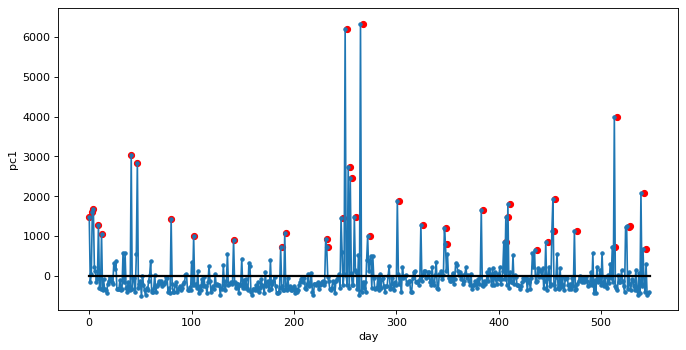

In [43]:
# pc1 GESD
figure(figsize=(10, 5), dpi=80)
plt.plot(range(df_pca.shape[0]), df_pca['pc1'], marker = 'o', markersize = 3)
plt.scatter(list(outlier_df2(df_pca,'pc1').iloc[:,0]),list(outlier_df2(df_pca,'pc1').iloc[:,1]),s=30, color ='r')
plt.plot([0, df_pca.shape[0]], [np.mean(df_pca.iloc[:,1]),np.mean(df_pca.iloc[:,1])], 'k-', lw=2)
plt.xlabel('day')
plt.ylabel('pc1')


C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Text(0, 0.5, 'pc2')

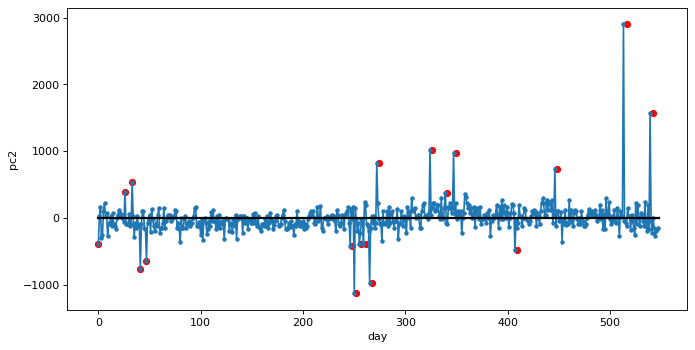

In [44]:
# pc2 GESD
figure(figsize=(10, 5), dpi=80)
plt.plot(range(df_pca.shape[0]), df_pca['pc2'], marker = 'o', markersize = 3)
plt.scatter(list(outlier_df2(df_pca,'pc2').iloc[:,0]),list(outlier_df2(df_pca,'pc2').iloc[:,1]),s=30, color ='r')
plt.plot([0, df_pca.shape[0]], [np.mean(df_pca.iloc[:,2]),np.mean(df_pca.iloc[:,2])], 'k-', lw=2)
plt.xlabel('day')
plt.ylabel('pc2')


# 4. Comparing outliers detected by 1,2

## 4-1. comparing one-variable GESD/two-variable PCA GESD

In [45]:
a = list(outlier_df('total_t').day)
b = list(outlier_df('micro_t').day)
a.extend(b)

joint_day1 = list(set(a))
joint_day2 = list(df_pca.loc[joint_ind,'day'])
del a,b

joint_day1.sort()
joint_day2.sort()
# total_t, micro_t를 각각 따로 GESD anomaly detection하는 경우보다
# 두 변수를 PCA하여 component2개로 GESD anomaly detection하는 경우가 더 유연하게 detect하는 모습

# 따로 했을 때만 outlier로 분류된 날짜
only1day = [day for day in joint_day1 if day not in joint_day2]

C:\Users\Kyeongjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


## 4-2. comparing cooktime

Text(0, 0.5, 'total_t')

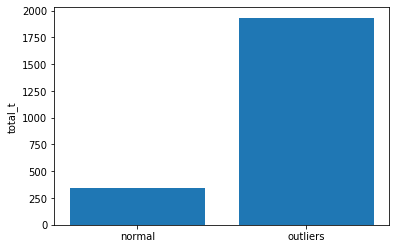

In [46]:
plt.bar(['normal','outliers'],[np.mean(df.loc[~df['day'].isin(joint_day1),'total_t']),np.mean(df.loc[df['day'].isin(joint_day1),'total_t'])])
plt.ylabel('total_t')

Text(0, 0.5, 'micro_t')

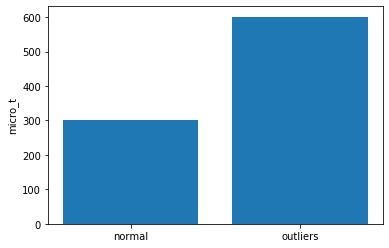

In [47]:
plt.bar(['normal','outliers'],[np.mean(df.loc[~df['day'].isin(joint_day1),'micro_t']),np.mean(df.loc[df['day'].isin(joint_day1),'micro_t'])])
plt.ylabel('micro_t')


## 4-3. 변수를 따로 사용했을 때만 outlier로 구분된 데이터 파악

Text(0, 0.5, 'micro_t')

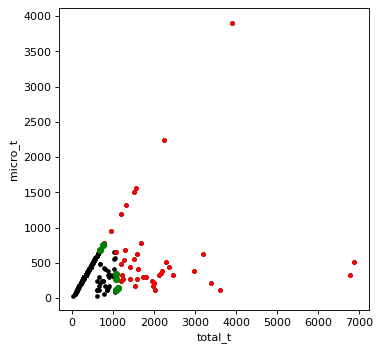

In [48]:
df.loc[df['day'].isin(only1day),:]

# joint control region
figure(figsize=(5, 5), dpi=80)
plt.scatter(df['total_t'], df['micro_t'], s=10, color='k')
plt.scatter(list(df.loc[df['day'].isin(joint_day2),'total_t']),list(df.loc[df['day'].isin(joint_day2),'micro_t']),s=10, color ='r')
plt.scatter(list(df.loc[df['day'].isin(only1day),'total_t']),list(df.loc[df['day'].isin(only1day),'micro_t']),s=30, color ='g')
plt.xlabel('total_t')
plt.ylabel('micro_t')

PCA로 두개 변수의 principal components를 이용해 GESD Anomaly detection하면
1개씩 따로 detecting할 때보다 관대하게 구분합니다.